In [1]:
from contra_qa.text_generation.boolean3_NP_and import boolean3
from contra_qa.text_generation.boolean4_VP_and import boolean4
from contra_qa.text_generation.boolean5_AP_and import boolean5
from contra_qa.text_processing.functions import simple_pre_process_text_df
from contra_qa.plots.functions  import plot_histogram_from_labels

from contra_qa.train_functions.RNNConfig import RNNConfig
import numpy as np
import torch
import torch.nn as nn
from torchtext import data

import pandas as pd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

% matplotlib inline

# manipulating datasets

In [2]:
boolean3()
# boolean4()
# boolean5()

In [3]:
df3 = pd.read_csv("data/boolean3_train.csv")
df3test = pd.read_csv("data/boolean3_test.csv")

In [4]:
df3.tail()

,sentence1,sentence2,and_A,and_B,label
9995,Geneva has visited Lugoj and Giurgiu,Geneva didn't visit Bucharest,Geneva has visited Lugoj,Geneva has visited Giurgiu,0
9996,Jeff has traveled to Deva and Hunedoara,Jeff didn't travel to Deva,Jeff has traveled to Deva,Jeff has traveled to Hunedoara,1
9997,Tyrone and Micheal have visited Dej,Micheal didn't visit Dej,Tyrone has visited Dej,Micheal has visited Dej,1
9998,Yvonne and Kristen have visited Slobozia,Kristen didn't visit Slobozia,Yvonne has visited Slobozia,Kristen has visited Slobozia,1
9999,Allan and Julia have visited Reghin,Julia didn't visit Reghin,Allan has visited Reghin,Julia has visited Reghin,1


In [5]:
df3test.tail()

,sentence1,sentence2,and_A,and_B,label
995,Dennis and Glen have traveled to Bucharest,Dennis didn't travel to Slobozia,Dennis has traveled to Bucharest,Glen has traveled to Bucharest,0
996,Ben and Kristi have visited Slatina,Ben didn't visit Slatina,Ben has visited Slatina,Kristi has visited Slatina,1
997,Byron has visited Slobozia and Hunedoara,Byron didn't visit Giurgiu,Byron has visited Slobozia,Byron has visited Hunedoara,0
998,Jamie has traveled to Reghin and Cluj-Napoca,Jamie didn't travel to Cluj-Napoca,Jamie has traveled to Reghin,Jamie has traveled to Cluj-Napoca,1
999,Pauline went to Timisoara and Deva,Pauline didn't go to Bucharest,Pauline went to Timisoara,Pauline went to Deva,0


In [6]:
df3train = df3.iloc[:8500]
df3valid = df3.iloc[8500:]

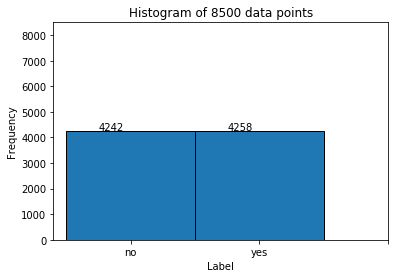

In [7]:
plot_histogram_from_labels(df3train.label.values, ["no", "yes"], "test.png") 

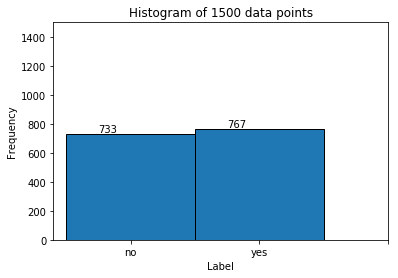

In [8]:
plot_histogram_from_labels(df3valid.label.values, ["no", "yes"], "test.png")

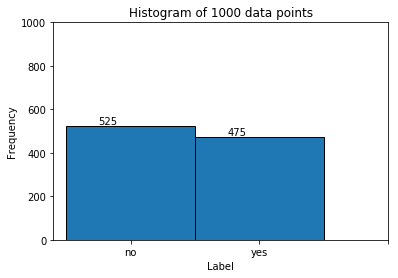

In [9]:
plot_histogram_from_labels(df3test.label.values, ["no", "yes"], "test.png") 

In [10]:
simple_pre_process_text_df(df3, "sentence1")
simple_pre_process_text_df(df3, "sentence2")
simple_pre_process_text_df(df3, "and_A")
simple_pre_process_text_df(df3, "and_B")

df3["text"] = df3["sentence1"] + ", " + df3["sentence2"]

# creating vocab and tensor data

In [11]:
df3_little = df3[["text", "label"]]

In [12]:
df3_little.head()

,text,label
0,"molly and armando have visited bucharest, judy...",0
1,"jeffrey has traveled to timisoara and lugoj, s...",0
2,"irene went to dej and timisoara, irene didnt g...",1
3,"ana and loretta have traveled to slatina, ana ...",0
4,"tanya and lola have traveled to dej, lawrence ...",0


In [13]:
train_data_path = "data/boolean_3_train_lab.csv"
df3_little.to_csv(train_data_path, header=False, index=False)

In [14]:
TEXT = data.Field()
LABEL = data.LabelField(tensor_type=torch.FloatTensor)
train = data.TabularDataset(path=train_data_path,
                            format="csv",
                            fields=[('text', TEXT), ('label', LABEL)])

In [15]:
TEXT.build_vocab(train, max_size=25000)
LABEL.build_vocab(train)

In [16]:
print('len(TEXT.vocab):', len(TEXT.vocab))
print('len(LABEL.vocab):', len(LABEL.vocab))

len(TEXT.vocab): 708
len(LABEL.vocab): 2


In [17]:
def finde_size(list_):
    return np.max(list(map(lambda x: len(x.split(" ")), list_)))

In [18]:
def str_list2tensor(list_):
    list_i = []
    max_size = finde_size(list_)
    for line in list_:
        line = line.split(" ")
        size = len(line) 
        tail = max_size - size
        line += [TEXT.pad_token] * tail
        new_line = [TEXT.vocab.stoi[word] for word in line]
        list_i.append(new_line)
    return torch.tensor(list_i, dtype=torch.long, device=device)
    

In [19]:
exampleS1_train_t = str_list2tensor(list(df3train.sentence1.values))
exampleS2_train_t = str_list2tensor(list(df3train.sentence2.values))
exampleA_train_t = str_list2tensor(list(df3train.and_A.values))
exampleB_train_t = str_list2tensor(list(df3train.and_B.values))
exampleLabel_train = torch.tensor(list(df3train.label.values), dtype=torch.long, device=device)

In [20]:
exampleS1_valid_t = str_list2tensor(list(df3valid.sentence1.values))
exampleS2_valid_t = str_list2tensor(list(df3valid.sentence2.values))
exampleA_valid_t = str_list2tensor(list(df3valid.and_A.values))
exampleB_valid_t = str_list2tensor(list(df3valid.and_B.values))
exampleLabel_valid = torch.tensor(list(df3valid.label.values), dtype=torch.long, device=device)

In [21]:
exampleS1_test_t = str_list2tensor(list(df3test.sentence1.values))
exampleS2_test_t = str_list2tensor(list(df3test.sentence2.values))
exampleA_test_t = str_list2tensor(list(df3test.and_A.values))
exampleB_test_t = str_list2tensor(list(df3test.and_B.values))
exampleLabel_test = torch.tensor(list(df3test.label.values), dtype=torch.long, device=device)

In [22]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(exampleS1_train_t, exampleS2_train_t, exampleA_train_t, exampleB_train_t, exampleLabel_train)
valid_dataset = TensorDataset(exampleS1_valid_t, exampleS2_valid_t, exampleA_valid_t, exampleB_valid_t, exampleLabel_valid)
test_dataset = TensorDataset(exampleS1_test_t, exampleS2_test_t, exampleA_test_t, exampleB_test_t, exampleLabel_test)

In [23]:
from torch.utils.data import DataLoader

class DataHolder():
    """
    Class to store all data using the GentleLoader.

    :param config: hyper params configuration
    :type config: LRConfig or DFNConfig
    :param train_dataset: dataset of training data
    :type train_dataset: torch.utils.data.dataset.TensorDataset
    :param test_dataset: dataset of test data
    :type test_dataset: torch.utils.data.dataset.TensorDataset
    :param valid_dataset: dataset of valid data
    :type valid_dataset: torch.utils.data.dataset.TensorDataset
    :param batch_size: batch size for training
    :type test_batch: batch size for the testing data
    :param test_batch: int
    """
    def __init__(self,
                 config,
                 train_dataset,
                 valid_dataset,
                 test_dataset,
                 test_batch=1000):
        batch_size = config.batch_size
        self.train_loader = DataLoader(dataset=train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)
        self.valid_loader = DataLoader(dataset=valid_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)
        self.test_loader = DataLoader(dataset=test_dataset,
                                        batch_size=test_batch,
                                        shuffle=True)

In [24]:
config = RNNConfig()
b_data = DataHolder(config,
                    train_dataset,
                    valid_dataset,
                    test_dataset)

# defining the model

In [25]:
class AddRNN(nn.Module):
    def __init__(self,
                 vocab_size,
                 hidden_size,
                 output_size):
        super(AddRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.GRU(hidden_size, hidden_size) 
        self.fcA = nn.Linear(hidden_size, hidden_size)
        self.fcB = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, output_size)
#         self.fc_inf = nn.Linear(hidden_size * 2, hidden_size)
        
        
    def encode(self, x, hidden=None):
        if hidden is None:
            hidden = torch.zeros((1, x.shape[1], self.hidden_size), device=device)
        embedded = self.embedding(x)       
        output, hidden = self.rnn(embedded, hidden)
        hidden = hidden.squeeze(0)
        return hidden

    def forward(self, s1, s2):
        h = self.encode(s1)
        ha = self.fcA(h)
        hb = self.fcB(h)
        h_inf = ha + hb
#         h_inf = ha * hb
#         h_inf = self.fc_inf(torch.cat([ha, hb], dim=1))
        h_inf = h_inf.view((1, h_inf.shape[0], h_inf.shape[1]))
        s2_enc = self.encode(s2, h_inf)
        out = self.fc_out(s2_enc)
        return out

    def predict(self, s1, s2):
        out = self.forward(s1, s2)
        softmax = nn.Softmax(dim=1)
        out = softmax(out)
        indices = torch.argmax(out, 1)
        return indices

#     def evaluate_bach(self, batch):
#         prediction = self.predict(batch[0], batch[1])
#         labels = batch.label.type('torch.LongTensor')
#         correct = torch.sum(torch.eq(prediction, labels)).float()
#         accuracy = float(correct / labels.shape[0])
#         return accuracy, prediction, labels


In [26]:
s1, s2, and_A, and_B, label = next(iter(b_data.train_loader))
s1 = s1.view((s1.shape[1], s1.shape[0]))
s2 = s2.view((s2.shape[1], s2.shape[0]))
and_A = and_A.view((and_A.shape[1], and_A.shape[0]))
and_B = and_B.view((and_B.shape[1], and_B.shape[0]))

In [27]:
model = AddRNN(vocab_size=len(TEXT.vocab),
               hidden_size=10,
               output_size=2)

out = model.predict(s1, s2)
print(out)

tensor([0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 1])


In [28]:
# def train_in_epoch(model, iterator, optimizer, criterion, negative=False):
#     """
#     Train the model using all the data from the iterator

#     Negative is a flag to train the model to maximize the
#     loss function

#     :param model: RNN classification model
#     :type model: RNN
#     :param iterator: data iterator
#     :type iterator: data.BucketIterator
#     :param optimizer: torch optimizer
#     :type optimizer: optim.SGD, etc.
#     :param criterion: loss criterion
#     :type criterion: nn.CrossEntropyLoss
#     :param negative: control param
#     :type negative: boolean
#     :return: mean loss, mean accuracy
#     :rtype: float, float
#     """

#     epoch_loss = 0
#     epoch_acc = 0

#     model.train()

#     for batch in iterator:

#         optimizer.zero_grad()

#         logits = model(batch.text)
#         label = batch.label.type("torch.LongTensor")
#         loss = criterion(logits, label)
#         if negative:
#             loss = - loss
#         acc, _, _ = model.evaluate_bach(batch)

#         loss.backward()
#         optimizer.step()

#         epoch_loss += loss.item()
#         epoch_acc += acc

#     mean_loss = epoch_loss / len(iterator)
#     mean_acc = epoch_acc / len(iterator)

#     return mean_loss, mean_acc